In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import pathlib
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_DIR = pathlib.Path("c:/Users/Acer/Desktop/Forex-Signal-App")
DATA_DIR = BASE_DIR / "data" / "test"
MODEL_DIR = BASE_DIR / "models" / "signal_generator_v22"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Timeframes
TIMEFRAMES = ['5min', '15min', '30min', '1h']
TIMEFRAMES_MAP = {'5min': 'M5', '15min': 'M15', '30min': 'M30', '1h': 'H1'}

# Day Trading Parameters - ATR-based for Profit Factor optimization
# Risk:Reward = 1:1.5 (Favorable for Profit Factor)
TP_ATR_MULT = 1.5   # Target: 1.5x ATR
SL_ATR_MULT = 1.0   # Stop: 1.0x ATR
ATR_PERIOD = 14

# Sequence length for LSTM
SEQ_LENGTH = 20

print(f"V22 Configuration (Profit Factor Focus):")
print(f"  Target: {TP_ATR_MULT}x ATR")
print(f"  Stop: {SL_ATR_MULT}x ATR")
print(f"  Risk:Reward = 1:{TP_ATR_MULT/SL_ATR_MULT:.2f}")
print(f"  Profit Factor Target: >1.5")

V22 Configuration (Profit Factor Focus):
  Target: 1.5x ATR
  Stop: 1.0x ATR
  Risk:Reward = 1:1.50
  Profit Factor Target: >1.5


In [4]:
# 2. Data Loading & Feature Engineering
def calculate_indicators(df):
    df = df.copy()
    
    # Price Features
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    df['price_change'] = df['close'] - df['close'].shift(1)
    
    # Volatility (ATR)
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = abs(df['high'] - df['close'].shift(1))
    df['l-pc'] = abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=ATR_PERIOD).mean()
    df['atr_7'] = df['tr'].rolling(window=7).mean()
    
    # Moving Averages
    for period in [5, 10, 20, 50, 100]:
        df[f'sma_{period}'] = df['close'].rolling(window=period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    
    # MA Crossovers (Trend Signals)
    df['sma_5_20_cross'] = (df['sma_5'] > df['sma_20']).astype(int)
    df['sma_10_50_cross'] = (df['sma_10'] > df['sma_50']).astype(int)
    df['ema_5_20_cross'] = (df['ema_5'] > df['ema_20']).astype(int)
    
    # Price Position relative to MAs
    df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['atr']
    df['price_vs_sma50'] = (df['close'] - df['sma_50']) / df['atr']
    
    # RSI
    for period in [7, 14, 21]:
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['bb_mid'] = df['close'].rolling(window=20).mean()
    df['bb_std'] = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # Stochastic
    low_14 = df['low'].rolling(window=14).min()
    high_14 = df['high'].rolling(window=14).max()
    df['stoch_k'] = 100 * (df['close'] - low_14) / (high_14 - low_14)
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # ADX (Trend Strength)
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    df['plus_di'] = 100 * (pd.Series(df['plus_dm']).rolling(14).mean() / df['atr'])
    df['minus_di'] = 100 * (pd.Series(df['minus_dm']).rolling(14).mean() / df['atr'])
    df['dx'] = 100 * abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di'])
    df['adx'] = df['dx'].rolling(window=14).mean()
    
    # Momentum
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'] - df['close'].shift(period)
        df[f'roc_{period}'] = (df['close'] / df['close'].shift(period) - 1) * 100
    
    # Volatility Features
    df['volatility_5'] = df['log_return'].rolling(window=5).std()
    df['volatility_20'] = df['log_return'].rolling(window=20).std()
    
    # Lagged Returns
    for lag in [1, 2, 3, 5, 10]:
        df[f'return_lag_{lag}'] = df['log_return'].shift(lag)
    
    df.dropna(inplace=True)
    return df

def create_target_atr(df, forward_bars=12):
    """Create target based on ATR-based TP/SL (Day Trading)"""
    df = df.copy()
    targets = []
    
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df) - forward_bars):
        entry = closes[i]
        atr = atrs[i]
        
        tp = entry + (atr * TP_ATR_MULT)
        sl = entry - (atr * SL_ATR_MULT)
        
        outcome = 0  # No win
        
        for j in range(1, forward_bars + 1):
            if lows[i+j] <= sl:
                outcome = 0
                break
            if highs[i+j] >= tp:
                outcome = 1
                break
        
        targets.append(outcome)
    
    targets.extend([0] * forward_bars)
    df['target'] = targets
    return df

# Load Data
datasets = {}
forward_bars_map = {'5min': 24, '15min': 8, '30min': 4, '1h': 2}  # ~2 hour window

for tf in TIMEFRAMES:
    tf_code = TIMEFRAMES_MAP[tf]
    file_path = DATA_DIR / f"EURUSD_{tf_code}.csv"
    
    if file_path.exists():
        print(f"Loading {tf}...")
        df = pd.read_csv(file_path)
        df.columns = [c.lower() for c in df.columns]
        
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'])
            df.set_index('time', inplace=True)
        
        df = calculate_indicators(df)
        df = create_target_atr(df, forward_bars=forward_bars_map[tf])
        
        # Train/Test Split
        split_idx = int(len(df) * 0.8)
        datasets[tf] = {
            'train': df.iloc[:split_idx],
            'test': df.iloc[split_idx:]
        }
        
        win_rate = df['target'].mean() * 100
        print(f"  {tf}: {len(df)} rows, Win Rate: {win_rate:.1f}%")

print("\nData Loading Complete.")

Loading 5min...
  5min: 148402 rows, Win Rate: 39.6%
Loading 15min...
  15min: 49708 rows, Win Rate: 30.2%
Loading 30min...
  30min: 24808 rows, Win Rate: 21.4%
Loading 1h...
  1h: 12355 rows, Win Rate: 12.4%

Data Loading Complete.


In [5]:
# 3. Prepare Features for ML and DL

# Feature columns (exclude non-features)
exclude_cols = ['target', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'volume',
                'h-l', 'h-pc', 'l-pc', 'tr', 'up_move', 'down_move', 'plus_dm', 'minus_dm',
                'bb_std', 'bb_upper', 'bb_lower', 'bb_mid']

def get_feature_cols(df):
    return [c for c in df.columns if c not in exclude_cols]

def create_sequences(X, y, seq_length):
    """Create sequences for LSTM"""
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Prepare data structures
ml_data = {}
dl_data = {}
scalers = {}
feature_cols = {}

for tf in TIMEFRAMES:
    if tf not in datasets:
        continue
    
    print(f"\nPreparing {tf} data...")
    
    train_df = datasets[tf]['train']
    test_df = datasets[tf]['test']
    
    cols = get_feature_cols(train_df)
    feature_cols[tf] = cols
    
    X_train = train_df[cols].values
    y_train = train_df['target'].values
    X_test = test_df[cols].values
    y_test = test_df['target'].values
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[tf] = scaler
    
    # ML Data
    ml_data[tf] = {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_test': X_test_scaled,
        'y_test': y_test
    }
    
    # DL Sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LENGTH)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LENGTH)
    
    dl_data[tf] = {
        'X_train': X_train_seq,
        'y_train': y_train_seq,
        'X_test': X_test_seq,
        'y_test': y_test_seq
    }
    
    print(f"  ML: Train {X_train_scaled.shape}, Test {X_test_scaled.shape}")
    print(f"  DL: Train {X_train_seq.shape}, Test {X_test_seq.shape}")

print("\nData Preparation Complete.")


Preparing 5min data...
  ML: Train (118721, 45), Test (29681, 45)
  DL: Train (118701, 20, 45), Test (29661, 20, 45)

Preparing 15min data...
  ML: Train (39766, 45), Test (9942, 45)
  DL: Train (39746, 20, 45), Test (9922, 20, 45)

Preparing 30min data...
  ML: Train (19846, 45), Test (4962, 45)
  DL: Train (19826, 20, 45), Test (4942, 20, 45)

Preparing 1h data...
  ML: Train (9884, 45), Test (2471, 45)
  DL: Train (9864, 20, 45), Test (2451, 20, 45)

Data Preparation Complete.


In [6]:
# 4. Train ML Models
print("Training ML Models...")

ml_models = {}

for tf in TIMEFRAMES:
    if tf not in ml_data:
        continue
    
    print(f"\n=== {tf} ===")
    
    X_train = ml_data[tf]['X_train']
    y_train = ml_data[tf]['y_train']
    X_test = ml_data[tf]['X_test']
    y_test = ml_data[tf]['y_test']
    
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    models = {
        'xgb': xgb.XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=scale_weight,
            random_state=42, n_jobs=-1, verbosity=0
        ),
        'lgb': lgb.LGBMClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            scale_pos_weight=scale_weight,
            random_state=42, n_jobs=-1, verbose=-1
        ),
        'cat': CatBoostClassifier(
            iterations=300, learning_rate=0.05, depth=5,
            scale_pos_weight=scale_weight,
            random_seed=42, verbose=0, allow_writing_files=False
        ),
        'rf': RandomForestClassifier(
            n_estimators=200, max_depth=8,
            class_weight='balanced',
            random_state=42, n_jobs=-1
        ),
        'et': ExtraTreesClassifier(
            n_estimators=200, max_depth=8,
            class_weight='balanced',
            random_state=42, n_jobs=-1
        )
    }
    
    ml_models[tf] = {}
    
    for name, model in models.items():
        print(f"  Training {name}...", end=" ")
        model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"Acc: {acc:.4f}")
        
        ml_models[tf][name] = model

print("\nML Training Complete.")

Training ML Models...

=== 5min ===
  Training xgb... Acc: 0.5131
  Training lgb... Acc: 0.5183
  Training cat... Acc: 0.5142
  Training rf... Acc: 0.5511
  Training et... Acc: 0.5424

=== 15min ===
  Training xgb... Acc: 0.4774
  Training lgb... Acc: 0.4836
  Training cat... Acc: 0.4600
  Training rf... Acc: 0.4538
  Training et... Acc: 0.4257

=== 30min ===
  Training xgb... Acc: 0.5455
  Training lgb... Acc: 0.5286
  Training cat... Acc: 0.4984
  Training rf... Acc: 0.5494
  Training et... Acc: 0.5230

=== 1h ===
  Training xgb... Acc: 0.7556
  Training lgb... Acc: 0.7309
  Training cat... Acc: 0.6601
  Training rf... Acc: 0.7892
  Training et... Acc: 0.8231

ML Training Complete.


In [8]:
# 5. Train Deep Learning Models
print("Training Deep Learning Models...")

import tensorflow as tensorflow_lib  # Rename to avoid conflict with 'tf' variable
tensorflow_lib.random.set_seed(42)
np.random.seed(42)

dl_models = {}

def build_lstm_model(input_shape, name='lstm'):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name=name)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_gru_model(input_shape, name='gru'):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(32, return_sequences=False),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name=name)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_dense_model(input_shape, name='dense'):
    # Flatten sequence for Dense network
    from tensorflow.keras.layers import Flatten
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ], name=name)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

for tf_name in TIMEFRAMES:
    if tf_name not in dl_data:
        continue
    
    print(f"\n=== {tf_name} ===")
    
    X_train = dl_data[tf_name]['X_train']
    y_train = dl_data[tf_name]['y_train']
    X_test = dl_data[tf_name]['X_test']
    y_test = dl_data[tf_name]['y_test']
    
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Calculate class weights
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    class_weights = {0: 1.0, 1: n_neg/n_pos if n_pos > 0 else 1.0}
    
    dl_models[tf_name] = {}
    
    # LSTM
    print("  Training LSTM...", end=" ")
    lstm = build_lstm_model(input_shape)
    lstm.fit(X_train, y_train, epochs=50, batch_size=64,
             validation_split=0.2, callbacks=callbacks,
             class_weight=class_weights, verbose=0)
    loss, acc = lstm.evaluate(X_test, y_test, verbose=0)
    print(f"Acc: {acc:.4f}")
    dl_models[tf_name]['lstm'] = lstm
    
    # GRU
    print("  Training GRU...", end=" ")
    gru = build_gru_model(input_shape)
    gru.fit(X_train, y_train, epochs=50, batch_size=64,
            validation_split=0.2, callbacks=callbacks,
            class_weight=class_weights, verbose=0)
    loss, acc = gru.evaluate(X_test, y_test, verbose=0)
    print(f"Acc: {acc:.4f}")
    dl_models[tf_name]['gru'] = gru
    
    # Dense
    print("  Training Dense...", end=" ")
    dense = build_dense_model(input_shape)
    dense.fit(X_train, y_train, epochs=50, batch_size=64,
              validation_split=0.2, callbacks=callbacks,
              class_weight=class_weights, verbose=0)
    loss, acc = dense.evaluate(X_test, y_test, verbose=0)
    print(f"Acc: {acc:.4f}")
    dl_models[tf_name]['dense'] = dense

print("\nDL Training Complete.")

Training Deep Learning Models...

=== 5min ===
  Training LSTM... Acc: 0.4677
  Training GRU... Acc: 0.5779
  Training Dense... Acc: 0.5101

=== 15min ===
  Training LSTM... Acc: 0.4506
  Training GRU... Acc: 0.4300
  Training Dense... Acc: 0.3247

=== 30min ===
  Training LSTM... Acc: 0.3278
  Training GRU... Acc: 0.6892
  Training Dense... Acc: 0.2649

=== 1h ===
  Training LSTM... Acc: 0.3325
  Training GRU... Acc: 0.7079
  Training Dense... Acc: 0.3174

DL Training Complete.


In [10]:
# 6. Consensus System - Combine ML + DL Predictions (Single TF: M5 for simplicity)
print("Building Consensus System (Using M5 as base)...")

# Use M5 as the single timeframe for consensus
base_tf = '5min'

X_ml_test = ml_data[base_tf]['X_test']
X_dl_test = dl_data[base_tf]['X_test']
y_test_full = ml_data[base_tf]['y_test']

# Align to DL length (remove first SEQ_LENGTH from ML predictions)
y_test_aligned = y_test_full[SEQ_LENGTH:]

print(f"Test samples (aligned): {len(y_test_aligned)}")

# Collect all predictions
all_probs = {}

# ML Model Predictions (aligned to DL)
print("\nGenerating ML predictions...")
for name, model in ml_models[base_tf].items():
    probs = model.predict_proba(X_ml_test)[:, 1]
    all_probs[f'ml_{name}'] = probs[SEQ_LENGTH:]  # Align
    print(f"  {name}: {len(probs[SEQ_LENGTH:])} predictions")

# DL Model Predictions
print("\nGenerating DL predictions...")
for name, model in dl_models[base_tf].items():
    probs = model.predict(X_dl_test, verbose=0).flatten()
    all_probs[f'dl_{name}'] = probs
    print(f"  {name}: {len(probs)} predictions")

# Add target
all_probs['target'] = y_test_aligned

# Create DataFrame
consensus_df = pd.DataFrame(all_probs)
print(f"\nConsensus DataFrame Shape: {consensus_df.shape}")
print(consensus_df.head())

Building Consensus System (Using M5 as base)...
Test samples (aligned): 29661

Generating ML predictions...
  xgb: 29661 predictions
  lgb: 29661 predictions
  cat: 29661 predictions
  rf: 29661 predictions
  et: 29661 predictions

Generating DL predictions...
  lstm: 29661 predictions
  gru: 29661 predictions
  dense: 29661 predictions

Consensus DataFrame Shape: (29661, 9)
     ml_xgb    ml_lgb    ml_cat     ml_rf     ml_et   dl_lstm    dl_gru  \
0  0.528587  0.488553  0.512291  0.512444  0.489779  0.501877  0.437258   
1  0.478017  0.500086  0.491122  0.491679  0.478212  0.502168  0.443069   
2  0.482346  0.481950  0.476521  0.490073  0.479518  0.500921  0.436008   
3  0.443276  0.471342  0.461216  0.483368  0.485705  0.500128  0.427639   
4  0.453220  0.464921  0.459854  0.486131  0.486110  0.499114  0.429708   

   dl_dense  target  
0  0.450829       1  
1  0.434503       1  
2  0.448263       1  
3  0.456352       1  
4  0.464794       1  



Training Meta-Model for Consensus...

Top 10 Most Important Model Signals:
 Feature  Importance
   ml_rf    0.135912
  ml_xgb    0.132860
 dl_lstm    0.130024
  ml_cat    0.125920
  ml_lgb    0.122151
   ml_et    0.118536
  dl_gru    0.118000
dl_dense    0.116597


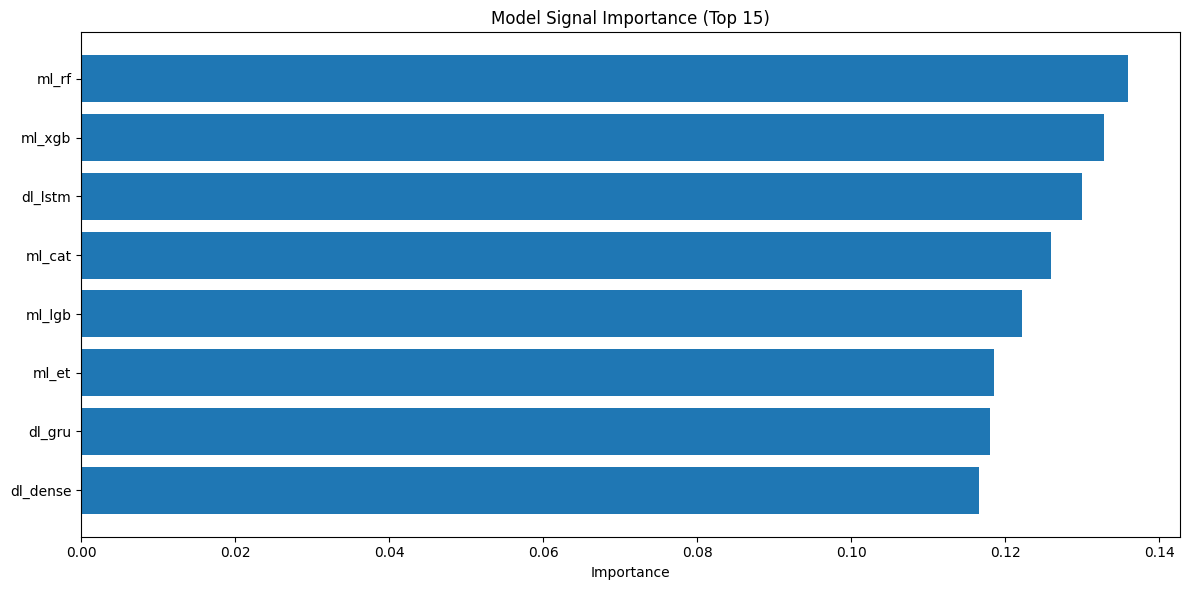

In [11]:
# 7. Meta-Model for Final Consensus
print("\nTraining Meta-Model for Consensus...")

# Features are all the probability columns
prob_cols = [c for c in consensus_df.columns if c != 'target']
X_consensus = consensus_df[prob_cols].values
y_consensus = consensus_df['target'].values

# Split
split_idx = int(len(consensus_df) * 0.5)
X_meta_train = X_consensus[:split_idx]
y_meta_train = y_consensus[:split_idx]
X_meta_test = X_consensus[split_idx:]
y_meta_test = y_consensus[split_idx:]

# XGBoost Meta-Model
meta_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
meta_model.fit(X_meta_train, y_meta_train)

# Feature Importance
importances = meta_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': prob_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Model Signals:")
print(importance_df.head(10).to_string(index=False))

# Plot Importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.title('Model Signal Importance (Top 15)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# 8. Backtest with Profit Factor Focus
print("\n" + "="*60)
print("BACKTEST FOR HIGH PROFIT FACTOR")
print("="*60)

# Get final probabilities
final_probs = meta_model.predict_proba(X_meta_test)[:, 1]

# Get aligned price data from M5 test set
test_df_aligned = datasets[base_tf]['test'].iloc[SEQ_LENGTH:].iloc[split_idx:].copy()
test_df_aligned = test_df_aligned.iloc[:len(final_probs)]  # Ensure alignment

closes = test_df_aligned['close'].values
highs = test_df_aligned['high'].values
lows = test_df_aligned['low'].values
atrs = test_df_aligned['atr'].values

# Duration for trades/day
time_diff = test_df_aligned.index[-1] - test_df_aligned.index[0]
days = time_diff.days + time_diff.seconds / 86400
print(f"Backtest Duration: {days:.1f} days")

# Test multiple thresholds
FORWARD_BARS = 24  # 24 * 5min = 2 hours
thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]

results = []

for threshold in thresholds:
    trades = []
    
    for i in range(len(final_probs) - FORWARD_BARS):
        if final_probs[i] >= threshold:
            entry = closes[i]
            atr = atrs[i]
            
            tp = entry + (atr * TP_ATR_MULT)
            sl = entry - (atr * SL_ATR_MULT)
            
            result = 'HOLD'
            pnl = 0
            
            for j in range(1, FORWARD_BARS + 1):
                if lows[i+j] <= sl:
                    result = 'LOSS'
                    pnl = sl - entry
                    break
                if highs[i+j] >= tp:
                    result = 'WIN'
                    pnl = tp - entry
                    break
            
            if result == 'HOLD':
                exit_price = closes[i + FORWARD_BARS]
                pnl = exit_price - entry
                result = 'TIME_EXIT'
            
            trades.append({'Result': result, 'PnL': pnl})
    
    if trades:
        df_trades = pd.DataFrame(trades)
        
        wins = len(df_trades[df_trades['Result'] == 'WIN'])
        losses = len(df_trades[df_trades['Result'] == 'LOSS'])
        time_exits = len(df_trades[df_trades['Result'] == 'TIME_EXIT'])
        
        win_rate = wins / len(df_trades) * 100
        total_pnl = df_trades['PnL'].sum()
        
        # Profit Factor
        gross_profit = df_trades[df_trades['PnL'] > 0]['PnL'].sum()
        gross_loss = abs(df_trades[df_trades['PnL'] < 0]['PnL'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
        
        trades_per_day = len(trades) / days if days > 0 else 0
        
        # Convert PnL to pips (1 pip = 0.0001)
        total_pips = total_pnl / 0.0001
        
        results.append({
            'Threshold': threshold,
            'Trades': len(trades),
            'Trades/Day': trades_per_day,
            'Wins': wins,
            'Losses': losses,
            'Win Rate %': win_rate,
            'Total Pips': total_pips,
            'Profit Factor': profit_factor
        })
    else:
        results.append({
            'Threshold': threshold, 'Trades': 0, 'Trades/Day': 0,
            'Wins': 0, 'Losses': 0, 'Win Rate %': 0,
            'Total Pips': 0, 'Profit Factor': 0
        })

results_df = pd.DataFrame(results)
print("\nResults by Threshold:")
print(results_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# Find best Profit Factor with at least 50 trades
valid_results = results_df[results_df['Trades'] >= 50]
if len(valid_results) > 0:
    best_pf = valid_results.loc[valid_results['Profit Factor'].idxmax()]
    print(f"\n*** Best Profit Factor: {best_pf['Profit Factor']:.2f} at Threshold {best_pf['Threshold']} ***")
    print(f"    Trades: {int(best_pf['Trades'])}, Win Rate: {best_pf['Win Rate %']:.1f}%, Total Pips: {best_pf['Total Pips']:.1f}")
else:
    best_pf = results_df.loc[results_df['Profit Factor'].idxmax()]
    print(f"\n*** Best Profit Factor: {best_pf['Profit Factor']:.2f} at Threshold {best_pf['Threshold']} ***")


BACKTEST FOR HIGH PROFIT FACTOR
Backtest Duration: 74.2 days

Results by Threshold:
 Threshold  Trades  Trades/Day  Wins  Losses  Win Rate %  Total Pips  Profit Factor
      0.50    1397       18.82   600     790       42.95      160.28           1.09
      0.55     690        9.29   311     377       45.07      162.70           1.20
      0.60     347        4.67   164     182       47.26      147.46           1.40
      0.65     193        2.60   102      91       52.85      131.40           1.83
      0.70     127        1.71    70      57       55.12       91.08           1.97
      0.75      75        1.01    42      33       56.00       49.46           1.98
      0.80      35        0.47    18      17       51.43       16.04           1.68
      0.85       2        0.03     1       1       50.00        1.23           2.00

*** Best Profit Factor: 1.98 at Threshold 0.75 ***
    Trades: 75, Win Rate: 56.0%, Total Pips: 49.5


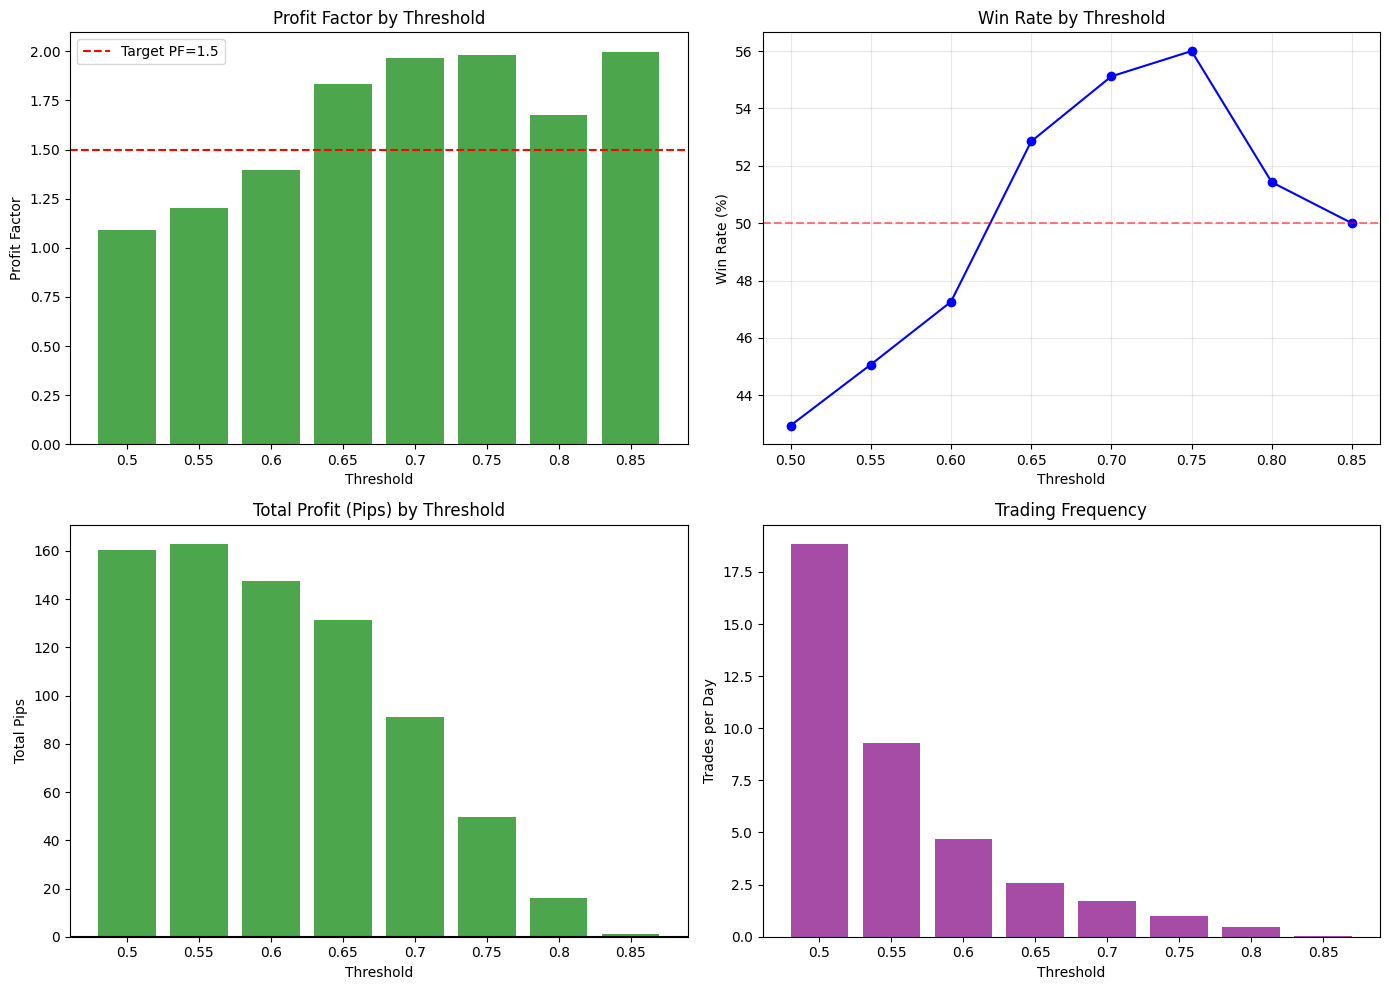


V22 SUMMARY - DL+ML HYBRID FOR HIGH PROFIT FACTOR
Models Used: 5 ML (XGB, LGB, Cat, RF, ET) + 3 DL (LSTM, GRU, Dense)
Base Timeframe: M5 (5min)
Target: 1.5x ATR, Stop: 1.0x ATR (R:R = 1:1.50)
Best Profit Factor: 1.98 @ Threshold 0.75
Win Rate: 56.0%
Total Pips: 49.5
Trades: 75 (1.0/day)


In [14]:
# 9. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Profit Factor by Threshold
ax1 = axes[0, 0]
ax1.bar(results_df['Threshold'].astype(str), results_df['Profit Factor'], color='green', alpha=0.7)
ax1.axhline(y=1.5, color='r', linestyle='--', label='Target PF=1.5')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Profit Factor')
ax1.set_title('Profit Factor by Threshold')
ax1.legend()

# Win Rate by Threshold
ax2 = axes[0, 1]
ax2.plot(results_df['Threshold'], results_df['Win Rate %'], marker='o', color='blue')
ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Win Rate (%)')
ax2.set_title('Win Rate by Threshold')
ax2.grid(True, alpha=0.3)

# Total Pips by Threshold
ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in results_df['Total Pips']]
ax3.bar(results_df['Threshold'].astype(str), results_df['Total Pips'], color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Total Pips')
ax3.set_title('Total Profit (Pips) by Threshold')

# Trades per Day
ax4 = axes[1, 1]
ax4.bar(results_df['Threshold'].astype(str), results_df['Trades/Day'], color='purple', alpha=0.7)
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Trades per Day')
ax4.set_title('Trading Frequency')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("V22 SUMMARY - DL+ML HYBRID FOR HIGH PROFIT FACTOR")
print("="*60)
print(f"Models Used: 5 ML (XGB, LGB, Cat, RF, ET) + 3 DL (LSTM, GRU, Dense)")
print(f"Base Timeframe: M5 (5min)")
print(f"Target: {TP_ATR_MULT}x ATR, Stop: {SL_ATR_MULT}x ATR (R:R = 1:{TP_ATR_MULT/SL_ATR_MULT:.2f})")
print(f"Best Profit Factor: {best_pf['Profit Factor']:.2f} @ Threshold {best_pf['Threshold']}")
print(f"Win Rate: {best_pf['Win Rate %']:.1f}%")
print(f"Total Pips: {best_pf['Total Pips']:.1f}")
print(f"Trades: {int(best_pf['Trades'])} ({best_pf['Trades/Day']:.1f}/day)")

In [15]:
# 10. Save Models
print("\nSaving V22 Models...")

# Save ML Models
for name, model in ml_models[base_tf].items():
    joblib.dump(model, MODEL_DIR / f"ml_{name}.joblib")
joblib.dump(scalers[base_tf], MODEL_DIR / f"scaler.joblib")

# Save DL Models
for name, model in dl_models[base_tf].items():
    model.save(MODEL_DIR / f"dl_{name}.keras")

# Save Meta-Model
joblib.dump(meta_model, MODEL_DIR / "meta_model.joblib")

# Save configuration
config = {
    'TP_ATR_MULT': TP_ATR_MULT,
    'SL_ATR_MULT': SL_ATR_MULT,
    'ATR_PERIOD': ATR_PERIOD,
    'SEQ_LENGTH': SEQ_LENGTH,
    'BASE_TF': base_tf,
    'feature_cols': feature_cols[base_tf],
    'best_threshold': float(best_pf['Threshold']),
    'best_profit_factor': float(best_pf['Profit Factor']),
    'ml_models': list(ml_models[base_tf].keys()),
    'dl_models': list(dl_models[base_tf].keys())
}
joblib.dump(config, MODEL_DIR / "config.joblib")

print(f"All models saved to {MODEL_DIR}")
print("\n" + "="*60)
print("V22 TRAINING COMPLETE!")
print("="*60)


Saving V22 Models...
All models saved to c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v22

V22 TRAINING COMPLETE!
